(notebook_id)=
# Bayesian Additive Regression Trees: Introduction
:::{post} Dec 21, 2021
:tags: , BART, Bayesian additive regression trees, non-parametric, pymc3.BART, pymc3.HalfNormal, pymc3.Model, pymc3.Normal, pymc3.Poisson, regression
:category: intermediate
:category: explanation
:author: Osvaldo Martin
:::

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_experimental as pmx

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0b6


In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## BART overview

Bayesian additive regression trees (BART) is a non-parametric regression approach. If we have some covariates $X$ and we want to use them to model $Y$, a BART model (omitting the priors) can be represented as:

$$Y = f(X) + \epsilon$$

where we use a sum of $m$ [regression trees](https://en.wikipedia.org/wiki/Decision_tree_learning) to model $f$, and $\epsilon$ is some noise. In the most typical examples $\epsilon$ is normally distributed, $\mathcal{N}(0, \sigma)$. So we can also write:

$$Y \sim \mathcal{N}(\mu=BART(X), \sigma)$$

In principle nothing restricts us to use a sum of trees to model other relationship. For example we may have:

$$Y \sim \text{Poisson}(\mu=BART(X))$$

One of the reason BART is Bayesian is the use of priors over the regression trees. The priors are defined in such a way that they favor shallow trees with leaf values close to zero. A key idea is that a single BART-tree is not very good at fitting the data but when we sum many of these trees we get a good and flexible approximation.

## Coal mining with BART

To better understand BART in practice we are going to use the oldie but goldie coal mining disaster dataset. One of the classic examples in PyMC. Instead of thinking this problem as a switch-point model with two Poisson distribution, as in the original PyMC example. We are going to think this problem as a non-parametric regression with a Poisson response (this is usually discussed in terms of [Poisson processes](https://en.wikipedia.org/wiki/Poisson_point_process) or [Cox processes](https://en.wikipedia.org/wiki/Cox_process), but we are OK without going into those technicalities). For a similar example but with Gaussian processes see [1](https://github.com/aloctavodia/BAP/blob/master/code/Chp7/07_Gaussian%20process.ipynb) or [2](https://research.cs.aalto.fi/pml/software/gpstuff/demo_lgcp.shtml). Because our data is just a single column with dates, we need to do some pre-processing. We are going to discretize the data, just as if we were building a histogram. We are going to use the centers of the bins as the variable $X$ and the counts per bin as the variable $Y$

In [3]:
try:
    coal = np.loadtxt(Path("..", "data", "coal.csv"))
except FileNotFoundError:
    coal = np.loadtxt(pm.get_data("coal.csv"))

In [4]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In PyMC a BART variable can be defined very similar to other random variables. One important difference is that we have to pass ours Xs and Ys to the BART variable. Here we are also making explicit that we are going to use a sum over 20 trees (`m=20`). Low number of trees like 20 could be good enough for simple models like this and could also work very good as a quick approximation for more complex models in particular during the iterative or explorative phase of modeling. In those cases once we have more certainty about the model we really like we can improve the approximation by increasing `m`, in the literature is common to find reports of good results with numbers like 50, 100 or 200.

In [5]:
with pm.Model() as model_coal:
    μ = pmx.BART("μ", X=x_data, Y=y_data, m=20)
    y_pred = pm.Poisson("y_pred", mu=pm.math.exp(μ), observed=y_data)
    idata_coal = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


The white line in the following plot shows the median rate of accidents. The darker orange band represent the HDI 50% and the lighter one the 94%. We can see a rapid decrease of coal accidents between 1880 and 1900. Feel free to compare these results with those in the original {ref}`pymc:pymc_overview` example.

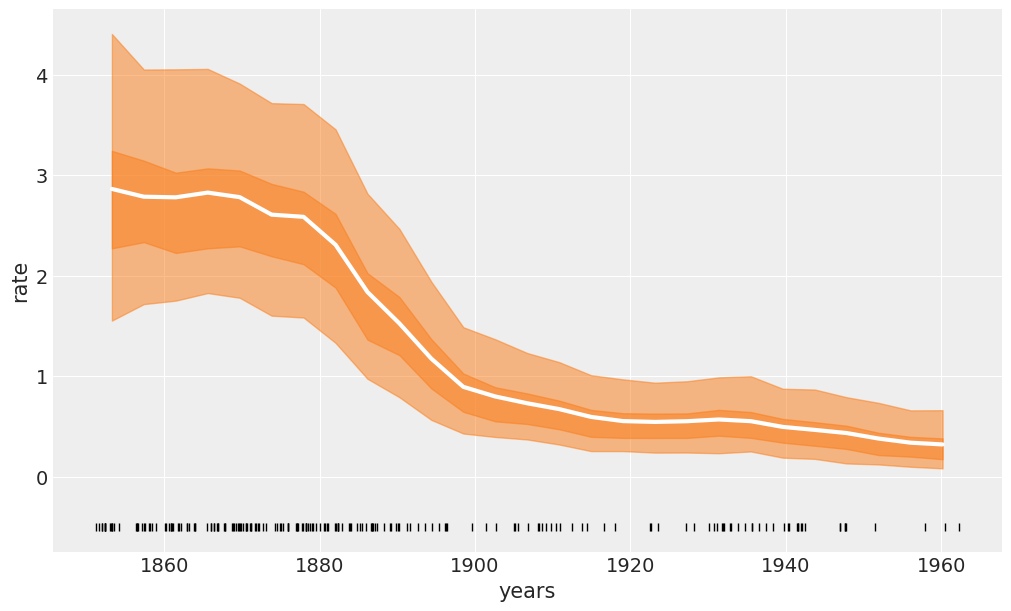

In [6]:
_, ax = plt.subplots(figsize=(10, 6))

rates = np.exp(idata_coal.posterior["μ"])
rate_median = np.exp(idata_coal.posterior["μ"].median(dim=["draw", "chain"]))
ax.plot(x_centers, rate_median, "w", lw=3)
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

In the previous plot the white line is the median over 4000 posterior draws, and each one of those posterior draws is a sum over `m=20` trees. 


The following figure shows two samples from the posterior of $\mu$. We can see that these functions are not smooth. This is fine and is a direct consequence of using regression trees. Trees can be seen as a way to represent stepwise functions, and a sum of stepwise functions is just another stepwise function. Thus, when using BART we just need to know that we are assuming that a stepwise function is a good enough approximation for our problem. In practice this is often the case because we sum over many trees, usually values like 50, 100 or 200. Additionally, we often average over the posterior distribution. All this makes the "steps smoother", even when we never really have an smooth function as for example with Gaussian processes (splines). A nice theoretical result, tells us that in the limit of $m \to \infty$ the BART prior converges to a [nowheredifferentiable](https://en.wikipedia.org/wiki/Weierstrass_function) Gaussian process.

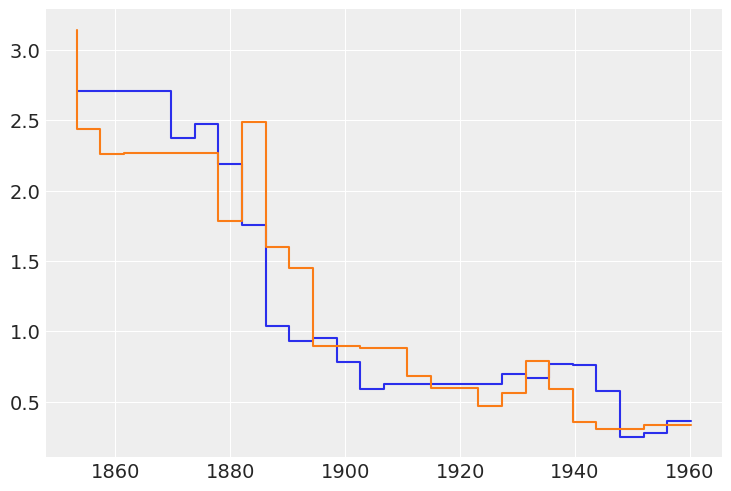

In [7]:
plt.step(x_data, np.exp(pmx.bart.predict(idata_coal, rng, x_data, size=2).T));

To gain further intuition the next figures show 3 of the `m` trees. As we can see these are definitely not very good approximators by themselves. inspecting individuals trees is generally not necessary. We are just showing them here to generate intuition about BART.

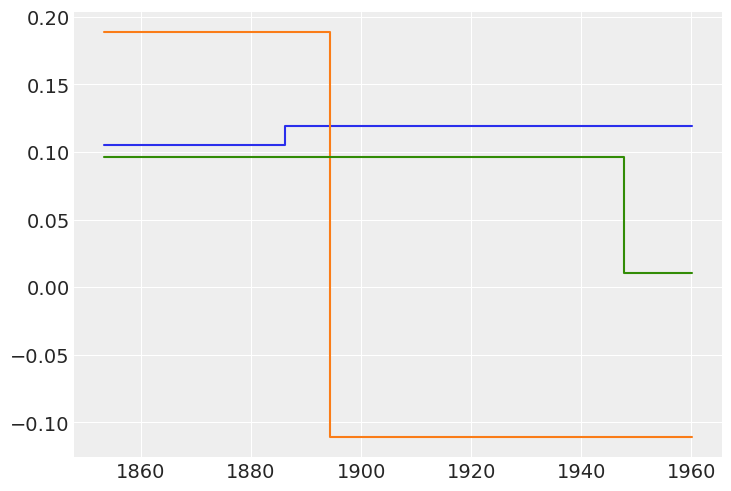

In [8]:
bart_trees = idata_coal.sample_stats.bart_trees
for i in [0, 1, 2]:
    plt.step(x_data[:, 0], [bart_trees[0, 0, i].item().predict(x) for x in x_data])

## Biking with BART

To explore other features offered by BART in PyMC. We are now going to move on to a different example. In this example we have data about the  number of bikes rental in a city, and we have chosen four covariates; the hour of the day, the temperature, the humidity and whether is a workingday or a weekend. This dataset is a subset of the [bike_sharing_dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [9]:
try:
    bikes = pd.read_csv(Path("..", "data", "bikes.csv"))
except FileNotFoundError:
    bikes = pd.read_csv(pm.get_data("bikes.csv"))

X = bikes[["hour", "temperature", "humidity", "workingday"]]
Y = bikes["count"]

In [10]:
with pm.Model() as model_bikes:
    σ = pm.HalfNormal("σ", Y.std())
    μ = pmx.BART("μ", X, Y, m=50)
    y = pm.Normal("y", μ, σ, observed=Y)
    idata_bikes = pm.sample(random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.9019, but should be close to 0.8. Try to increase the number of tuning steps.


### Partial dependence plots

To help us interpret the results of our model we are going to use partial dependence plot. This is a type of plot that shows the marginal effect that one covariate has on the predicted variable. That is, what is the effect that a covariate $X_i$ has of $Y$ while we average over all the other covariates ($X_j, \forall j \not = i$). This type of plot are not exclusive of BART. But they are often used in the BART literature. PyMC provides an utility function to make this plot from the inference data.

/home/osvaldo/anaconda3/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/pr

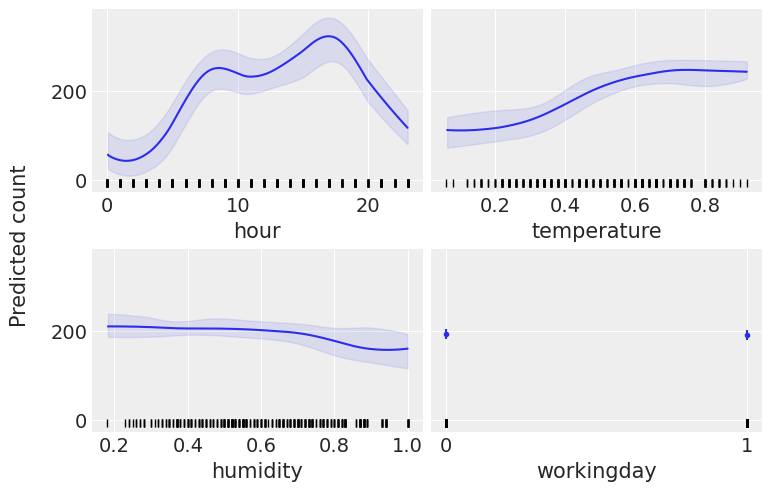

In [11]:
pmx.bart.plot_dependence(idata_bikes, X=X, Y=Y, grid=(2, 2), var_discrete=[3]);

From this plot we can see the main effect of each covariate on the predicted value. This is very useful we can recover complex relationship beyond monotonic increasing or decreasing effects. For example for the `hour` covariate we can see two peaks around 8 and and 17 hs and a minimum at midnight.

When interpreting partial dependence plots we should be careful about the assumptions in this plot. First we are assuming variables are independent. For example when computing the effect of `hour` we have to marginalize the effect of `temperature` and this means that to compute the partial dependence value at `hour=0` we are including all observed values of temperature, and this may include temperatures that are actually not observed at midnight, given that lower temperatures are more likely than higher ones. We are seeing only averages, so if for a covariate half the values are positively associated with predicted variable and the other half negatively associated. The partial dependence plot will be flat as their contributions will cancel each other out. This is a problem that can be solved by using instead individual conditional expectation plots `pm.bart.plot_dependence(idata_bikes, kind="ice")`. Notice that all this assumptions are assumptions of the partial dependence plot, not of our model! In fact BART can easily accommodate interaction of variables Although the prior in BART regularizes high order interactions). For more on interpreting Machine Learning model you could check this [book](https://christophm.github.io/interpretable-ml-book/).

Finally like with other regression method we should be careful that the effects we are seeing on individual variables are conditional on the inclusion of the other variables. So for example, while `humidity` seems to be mostly flat, meaning that this covariate has an small effect of the number of used bikes. This could be the case because `humidity` and `temperature` are correlated to some extend and once we include `temperature` in our model `humidity` does not provide too much information. Try for example fitting the model again but this time with `humidity` as the single covariate and then fitting the model again with `hour` as a single covariate. You should see that the result for this single-variate models will very similar to the previous figure for the `hour` covariate, but less similar for the `humidity` covariate.

### Variable importance

As we saw in the previous section a partial dependence plot can visualize give us an idea of how much each covariable contributes to the predicted outcome. But BART itself leads to a simple heuristic to estimate variable importance. Counting how many times each variable is included in the regression trees. The intuition is that a more important variable should appears more often in the fitted trees than a less important variable. While this heuristic seems to provide reasonable results in practice, there is not too much theory justifying this procedure, at least not yet.

The top panel in the following plot shows the relative importance in a scale from 0 to 1 (less to more importance) and the sum of the individual importance is 1. See that, at least in this case, the relative importance qualitative agrees with the partial dependence plot.


Additionally, we provide a novel method to assess the variable importance. You can see an example in the bottom panel. On the x-axis we have the number of components (variables) and on the y-axis the Pearson correlation between the predictions made between the full-model (all variables included) and the restricted-models, those with only a subset of the variables in the full-model. The components are included following the relative variable importance order, as show in the top panel. Thus, in this example 1 component means `hour`, two components means `hour` and `temperature`, 3 components `hour`, `temperature`and `humidity`. Finally, four components means `hour`, `temperature`, `humidity`, `workingday`, i.e., the full model. Hence, from the next figure we can see that even a model with a single component, `hour`, is very close to the full model. Even more, the model with two components `hour`, and `temperature` is on average indistinguishable from the full model. The error bars represent the 94 \% HDI from the posterior predictive distribution. It is important to notice that to compute these correlations we do not resample the models, instead the predictions of the restricted-models are approximated from the full-model.

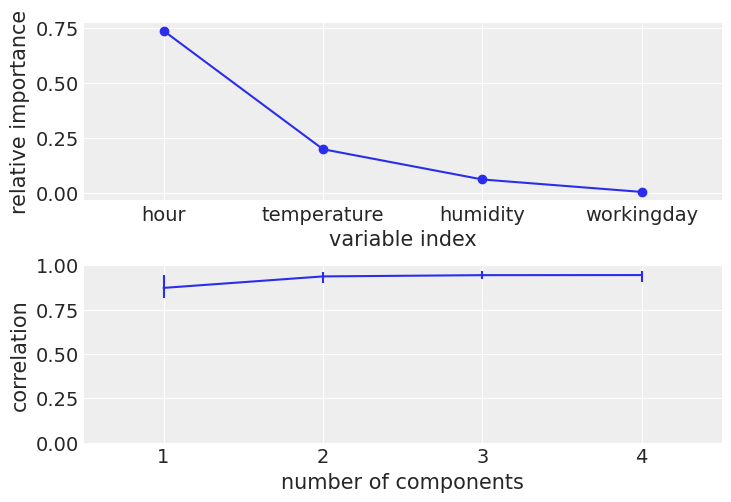

In [12]:
labels = ["hour", "temperature", "humidity", "workingday"]
pmx.bart.utils.plot_variable_importance(idata_bikes, X.values, labels, samples=100);

* Authored by Osvaldo Martin in Dec, 2021 ([pymc#259](https://github.com/pymc-devs/pymc-examples/pull/259))
* Updated by Osvaldo Martin in May, 2022

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri May 20 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.3.0

pymc             : 4.0.0b6
sys              : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib       : 3.5.1
arviz            : 0.12.0
pymc_experimental: 0.0.1
pandas           : 1.4.2
numpy            : 1.21.5

Watermark: 2.3.0



:::{include} ../page_footer.md
:::